<h3 align="right">hPu, &nbsp; dSPN, &nbsp; 150917_c6_D1, &nbsp; AB5_porta76_cel5 </h3>

# Model selection

## Model data

In [1]:
import cell_model, cell_evaluator
morphofile = 'morphology/AB5_porta76_cel5.swc'
parameters = cell_model.define_parameters('parameters.json')
mechanisms = cell_model.define_mechanisms('mechanisms.json')
protocols = cell_evaluator.define_protocols('protocols.json')
calculator = cell_evaluator.define_fitness_calculator(protocols, 'features.json')
expdata = {
    'IV_499.soma.v': 'expdata/ECBL_IV_ch5_499.dat',
    'IV_500.soma.v': 'expdata/ECBL_IV_ch5_500.dat',
    'IV_502.soma.v': 'expdata/ECBL_IV_ch5_502.dat',
    'IV_504.soma.v': 'expdata/ECBL_IV_ch5_504.dat',
    'IV_506.soma.v': 'expdata/ECBL_IV_ch5_506.dat',
    'IV_508.soma.v': 'expdata/ECBL_IV_ch5_508.dat'
}

/home/akozlov/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/akozlov/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


## Simulation environment

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [3]:
import json
import pandas
import efel
import numpy as np
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

In [4]:
from utils import *

In [5]:
%%capture
!rm -rf x86_64
!nrnivmodl mechanisms

## Cell model definition

In [6]:
morphology = ephys.morphologies.NrnFileMorphology(
    morphofile, do_replace_axon=True)

In [7]:
cell = ephys.models.CellModel(
    'dspn', 
    morph=morphology, 
    mechs=mechanisms, 
    params=parameters)
print (cell)

dspn:
  morphology:
    morphology/AB5_porta76_cel5.swc
  mechanisms:
    pas.all: pas at ['all']
    kir.somatic: kir at ['somatic']
    kir.basal: kir at ['basal']
  params:
    celsius: celsius = 35
    v_init: v_init = -85.0
    g_pas.axonal: ['axonal'] g_pas = [1e-05, 0.02]
    g_pas.somatic: ['somatic'] g_pas = [1e-05, 0.01]
    g_pas.basal: ['basal'] g_pas = [1e-05, 0.01]
    e_pas.all: ['all'] e_pas = [-90, -70]
    cm.axonal: ['axonal'] cm = 1
    cm.somatic: ['somatic'] cm = 1
    cm.basal: ['basal'] cm = 1
    Ra.all: ['all'] Ra = 150.0
    ek.somatic: ['somatic'] ek = -105.9
    ek.basal: ['basal'] ek = -105.9
    gbar_kir.somatic: ['somatic'] gbar_kir = [0, 0.1]
    shift_kir.somatic: ['somatic'] shift_kir = -20
    q_kir.somatic: ['somatic'] q_kir = 1
    gbar_kir.basal: ['basal'] gbar_kir = [0, 0.01]
    shift_kir.basal: ['basal'] shift_kir = -20
    q_kir.basal: ['basal'] q_kir = 1



In [8]:
opt_params = [p.name for p in cell.params.values() if not p.frozen]
opt_bounds = [p.bounds for p in cell.params.values() if not p.frozen]
for x in sorted(opt_params): print (x)

e_pas.all
g_pas.axonal
g_pas.basal
g_pas.somatic
gbar_kir.basal
gbar_kir.somatic


## Cell evaluator

In [9]:
simulator = ephys.simulators.NrnSimulator()

In [10]:
evaluator = ephys.evaluators.CellEvaluator(
    cell_model=cell,
    param_names=opt_params,
    fitness_protocols=protocols,
    fitness_calculator=calculator,
    sim=simulator)

## Optimisation results

In [11]:
with open('log.json') as fp:
    log = json.load(fp)

<IPython.core.display.Javascript object>


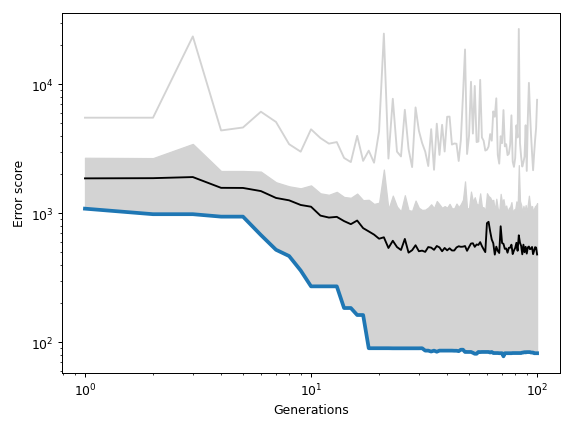

In [12]:
plot_log(log)

In [13]:
best_models = json.load(open('best_models.json'))
pandas.options.display.float_format = '{:,.4g}'.format
bm = pandas.DataFrame(best_models)
bm.T

,0,1,2,3,4,5,6,7,8,9
g_pas.axonal,0.0002547,0.01001,0.009836,0.005658,0.005658,0.009836,0.008546,0.002142,0.008621,0.005894
g_pas.somatic,0.0009129,1.558e-05,4.627e-05,0.0004677,0.0004677,4.579e-05,0.0001768,0.0008973,0.0001685,0.0004183
g_pas.basal,3.802e-05,1.389e-05,1.186e-05,1.055e-05,1.055e-05,1.002e-05,1.002e-05,1.387e-05,1.002e-05,1.049e-05
e_pas.all,-86.08,-86.67,-86.2,-86.11,-86.33,-86.12,-86.08,-86.08,-85.99,-86.08
gbar_kir.somatic,0.0001005,7.059e-06,3.099e-06,8.476e-06,2.828e-06,3.099e-06,4.626e-05,0.0002048,4.597e-05,3.385e-05
gbar_kir.basal,5.929e-05,4.816e-05,5.943e-05,5.883e-05,5.883e-05,5.926e-05,5.916e-05,4.854e-05,5.91e-05,5.916e-05


<IPython.core.display.Javascript object>


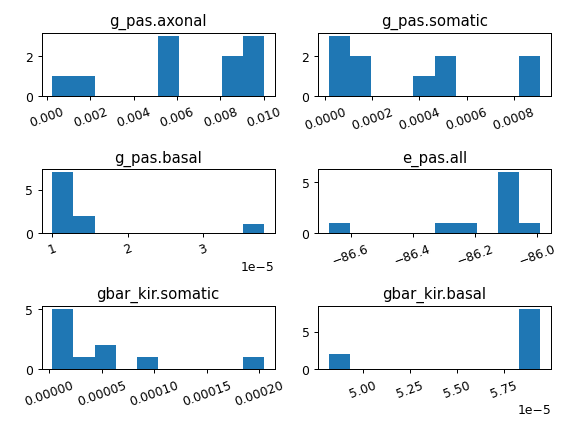

In [14]:
axs = bm.hist(grid=False, xrot=20)
plt.tight_layout();

<IPython.core.display.Javascript object>


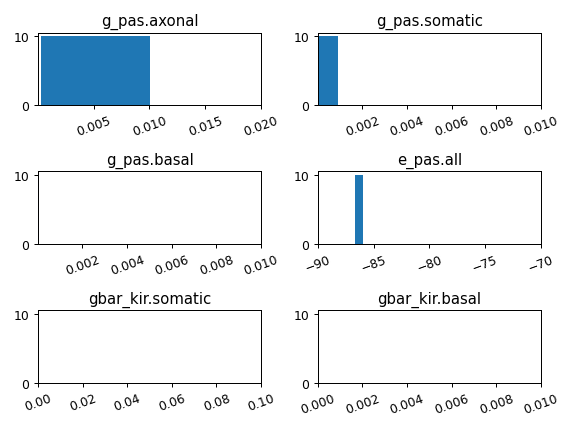

In [15]:
axs = bm.hist(bins=1, grid=False, xrot=20)
for ax, bounds in zip(axs.flatten(), opt_bounds):
        ax.set_xlim(bounds)
plt.tight_layout();

In [16]:
evaluate_all = True
best_objectives = []
if evaluate_all:
    for params in best_models:
        objectives = evaluator.evaluate_with_dicts(params)
        best_objectives.append(objectives)
    df = pandas.DataFrame(best_objectives).T
    df = df.sort_index(axis=0, ascending=False)

<IPython.core.display.Javascript object>


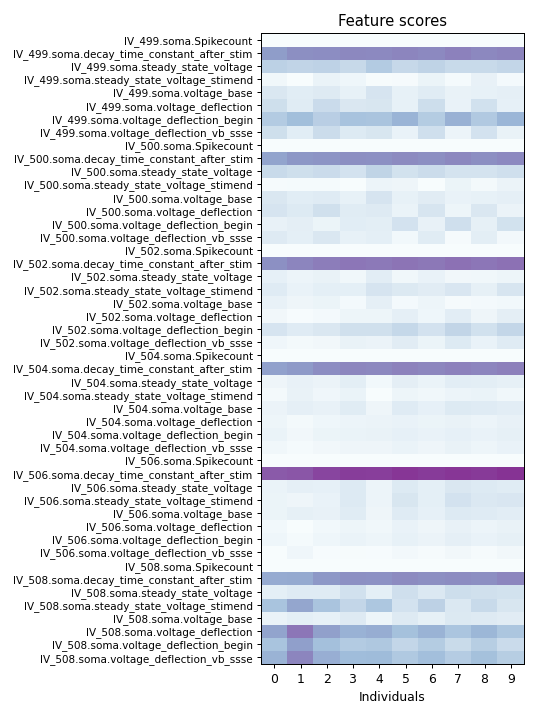

In [17]:
if evaluate_all:
    plot_scores(df, figsize=(6, 8), vmin=0, vmax=10)

## Single-cell simulation

In [18]:
ind = 0
test_parameters = best_models[ind]

In [19]:
test_responses = evaluator.run_protocols(
    protocols=protocols.values(), 
    param_values=test_parameters)

<IPython.core.display.Javascript object>


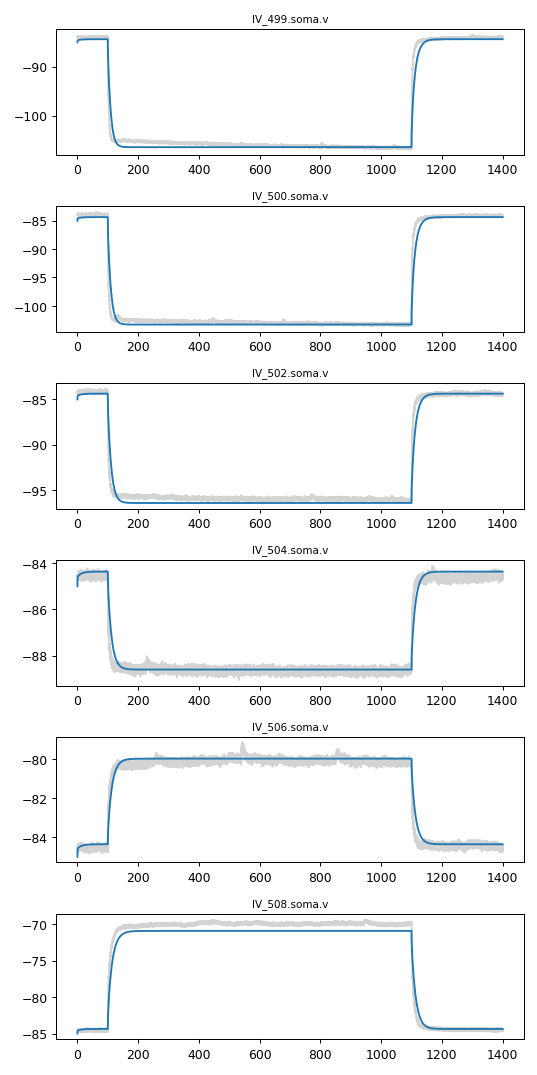

In [20]:
plot_responses(test_responses, expdata=expdata, junction_potential=11.5, figsize=(6,12))

<IPython.core.display.Javascript object>


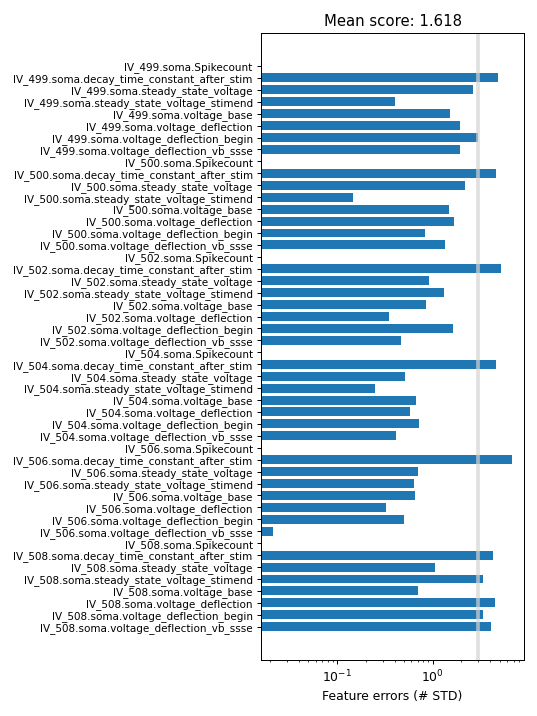

In [21]:
if evaluate_all:
    objectives = best_objectives[ind]
else:
    objectives = evaluator.evaluate_with_dicts(test_parameters)
plot_objectives(objectives, figsize=(6,8))

In [22]:
from numpy.linalg import norm
d = []
for i in range(len(best_models)):
    v = []
    for j in range(len(best_models)):
        p1 = np.array([best_models[i][p] for p in sorted(best_models[i])])
        p2 = np.array([best_models[j][p] for p in sorted(best_models[j])])
        v.append(norm((p1-p2)/(p1+p2)))
    d.append(v)
df = pandas.DataFrame(data=np.round(d,2))
def highlight_low(x):
    def c(v):
        r = int(v/x.max()*255)
        g = int(v/x.max()*128)+127
        b = 255
        return '#%02x%02x%02x' % (r, g, b)
    return ['background-color: %s' % c(v) for v in x]
df.style.apply(highlight_low)

,0,1,2,3,4,5,6,7,8,9
0,0.000000,1.680000,1.700000,1.400000,1.470000,1.720000,1.350000,0.980000,1.360000,1.240000
1,1.680000,0.000000,0.640000,0.990000,1.080000,0.660000,1.130000,1.490000,1.130000,1.180000
2,1.700000,0.640000,0.000000,0.980000,0.870000,0.080000,1.060000,1.480000,1.050000,1.180000
3,1.400000,0.990000,0.980000,0.000000,0.500000,0.980000,0.850000,1.090000,0.860000,0.600000
4,1.470000,1.080000,0.870000,0.500000,0.000000,0.870000,1.010000,1.130000,1.020000,0.850000
5,1.720000,0.660000,0.080000,0.980000,0.870000,0.000000,1.060000,1.480000,1.050000,1.180000
6,1.350000,1.130000,1.060000,0.850000,1.010000,1.060000,0.000000,1.120000,0.020000,0.470000
7,0.980000,1.490000,1.480000,1.090000,1.130000,1.480000,1.120000,0.000000,1.130000,0.940000
8,1.360000,1.130000,1.050000,0.860000,1.020000,1.050000,0.020000,1.130000,0.000000,0.490000
9,1.240000,1.180000,1.180000,0.600000,0.850000,1.180000,0.470000,0.940000,0.490000,0.000000


In [23]:
hall_of_fame = []
selected = range(10)
for model in selected:
    hall_of_fame.append(best_models[model])
with open('hall_of_fame.json', 'w') as fp:
    json.dump(hall_of_fame, fp, indent=4, sort_keys=True)

In [24]:
e_pas = np.mean([x['e_pas.all'] for x in best_models])
#Ra = np.mean([x['Ra.all'] for x in best_models])
#shift_kir = np.mean([x['shift_kir.somatic'] for x in best_models] + [x['shift_kir.basal'] for x in best_models])

In [25]:
print(f'{e_pas=}')

e_pas=-86.1743175336617


In [26]:
best_models[0]['e_pas.all'] #, best_models[0]['shift_kir.somatic']

-86.08166339846443